In [1]:
import numpy
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
# import pycountry
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import numba
import copy
import glob
from numba import njit
import pandas
import glob

In [2]:
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools

In [3]:
ta_data=eua.vm_request_wrapper( {'variable': 'temperature',
                              'statid': '72357',
                              'date':['19000101', '20201231'],
#                                 'cdm':['observations_table/conversion_flag']
                         }, overwrite=True, vm_url='http://srvx8.img.univie.ac.at:8000')
ta_data = ta_data.to_dataframe()
ta_data

,lat,lon,obs,plev,report_id,station_id,ta,time,trajectory_label
0,35.43,-97.550003,0,13200.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",NaN,1928-03-15 13:08:00,nnnnnnnnnnn
1,35.43,-97.550003,0,20000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",NaN,1928-03-15 13:08:00,nnnnnnnnnnn
2,35.43,-97.550003,0,23600.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",NaN,1928-03-15 13:08:00,nnnnnnnnnnn
3,35.43,-97.550003,0,27000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",NaN,1928-03-15 13:08:00,nnnnnnnnnnn
4,35.43,-97.550003,0,30000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",NaN,1928-03-15 13:08:00,nnnnnnnnnnn
...,...,...,...,...,...,...,...,...,...
2469088,35.18,-97.440002,0,85000.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",276.000000,2020-12-31 12:00:00,nnnnnnnnnnn
2469089,35.18,-97.440002,0,90900.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",274.200012,2020-12-31 12:00:00,nnnnnnnnnnn
2469090,35.18,-97.440002,0,92500.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",272.899994,2020-12-31 12:00:00,nnnnnnnnnnn
2469091,35.18,-97.440002,0,93700.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",272.299988,2020-12-31 12:00:00,nnnnnnnnnnn


In [4]:
sh_data=eua.vm_request_wrapper( {'variable': 'specific_humidity',
                              'statid': '72357',
                              'date':['19000101', '20201231'],
                                 'cdm':['observations_table/conversion_flag']
                         }, overwrite=True, vm_url='http://srvx8.img.univie.ac.at:8000')
sh_data = sh_data.to_dataframe()
sh_data = sh_data.rename(columns={'conversion_flag':'sh_cf'})
sh_data

,sh_cf,hus,lat,lon,obs,plev,report_id,station_id,time,trajectory_label
0,0,NaN,35.43,-97.550003,0,13200.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
1,0,NaN,35.43,-97.550003,0,20000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
2,0,NaN,35.43,-97.550003,0,23600.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
3,0,NaN,35.43,-97.550003,0,27000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
4,0,NaN,35.43,-97.550003,0,30000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
...,...,...,...,...,...,...,...,...,...,...
1747443,-2147483648,0.000506,35.18,-97.440002,0,90900.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1747444,-2147483648,0.001159,35.18,-97.440002,0,92500.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1747445,-2147483648,0.002083,35.18,-97.440002,0,93700.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1747446,-2147483648,0.002566,35.18,-97.440002,0,97400.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn


In [5]:
dpd_data=eua.vm_request_wrapper( {'variable': 'dew_point_depression',
                              'statid': '72357',
                              'date':['19000101', '20201231'],
                                  'cdm':['observations_table/conversion_flag']
                         }, overwrite=True, vm_url='http://srvx8.img.univie.ac.at:8000')
dpd_data = dpd_data.to_dataframe()
dpd_data = dpd_data.rename(columns={'conversion_flag':'dpd_cf'})

dpd_data

,dpd_cf,dew_point_depression,lat,lon,obs,plev,report_id,station_id,time,trajectory_label
0,0,NaN,35.43,-97.550003,0,13200.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
1,0,NaN,35.43,-97.550003,0,20000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
2,0,NaN,35.43,-97.550003,0,23600.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
3,0,NaN,35.43,-97.550003,0,27000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
4,0,NaN,35.43,-97.550003,0,30000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
...,...,...,...,...,...,...,...,...,...,...
1686885,0,49.139999,35.18,-97.440002,0,85000.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1686886,0,27.000000,35.18,-97.440002,0,90900.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1686887,0,15.970000,35.18,-97.440002,0,92500.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1686888,0,7.950000,35.18,-97.440002,0,93700.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn


In [6]:
rh_data=eua.vm_request_wrapper( {'variable': 'relative_humidity',
                              'statid': '72357',
                              'date':['19000101', '20201231'],
                                 'cdm':['observations_table/conversion_flag']
                         }, overwrite=True, vm_url='http://srvx8.img.univie.ac.at:8000')
rh_data = rh_data.to_dataframe()
rh_data = rh_data.rename(columns={'conversion_flag':'rh_cf'})
rh_data

,rh_cf,hur,lat,lon,obs,plev,report_id,station_id,time,trajectory_label
0,0,NaN,35.43,-97.550003,0,13200.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
1,0,NaN,35.43,-97.550003,0,20000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
2,0,NaN,35.43,-97.550003,0,23600.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
3,0,NaN,35.43,-97.550003,0,27000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
4,0,NaN,35.43,-97.550003,0,30000.0,nnnnnnnnnnn,"NORMAN/MAX WESTHEIMER A, OK.",1928-03-15 13:08:00,nnnnnnnnnnn
...,...,...,...,...,...,...,...,...,...,...
1763412,-2147483648,0.012895,35.18,-97.440002,0,85000.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1763413,-2147483648,0.112098,35.18,-97.440002,0,90900.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1763414,-2147483648,0.287211,35.18,-97.440002,0,92500.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn
1763415,-2147483648,0.545861,35.18,-97.440002,0,93700.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn


In [7]:
df1 = pd.merge(rh_data, ta_data, on=["time", "plev",'report_id', 'station_id', 'trajectory_label', 'obs', 'lat', 'lon'], how='outer')

In [8]:
df2 = pd.merge(df1, sh_data, on=["time", "plev",'report_id', 'station_id', 'trajectory_label', 'obs', 'lat', 'lon'], how='outer')

In [9]:
df3 = pd.merge(df2, dpd_data, on=["time", "plev",'report_id', 'station_id', 'trajectory_label', 'obs', 'lat', 'lon'], how='outer')

In [10]:
df3[df3.hur < 0]

,rh_cf,hur,lat,lon,obs,plev,report_id,station_id,time,trajectory_label,ta,sh_cf,hus,dpd_cf,dew_point_depression
45328,-2.147484e+09,-0.17,35.400002,-97.599998,0,50000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,256.850006,NaN,NaN,NaN,NaN
45331,-2.147484e+09,-0.14,35.400002,-97.599998,0,65000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,271.750000,NaN,NaN,NaN,NaN
45332,-2.147484e+09,-0.14,35.400002,-97.599998,0,70000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,274.049988,NaN,NaN,NaN,NaN
45333,-2.147484e+09,-0.13,35.400002,-97.599998,0,75000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,276.950012,NaN,NaN,NaN,NaN
45339,-2.147484e+09,-0.21,35.400002,-97.599998,0,35000.0,20000000001,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 15:00:00,nnnnnnnnnnn,238.750000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258017,-2.147484e+09,-0.12,35.400002,-97.599998,0,80000.0,20000013406,"NORMAN/MAX WESTHEIMER A, OK.",1964-10-31 00:00:00,nnnnnnnnnnn,286.950012,NaN,NaN,NaN,NaN
258040,-2.147484e+09,-0.20,35.400002,-97.599998,0,35000.0,20000013407,"NORMAN/MAX WESTHEIMER A, OK.",1964-10-31 12:00:00,nnnnnnnnnnn,240.350006,NaN,NaN,NaN,NaN
258041,-2.147484e+09,-0.18,35.400002,-97.599998,0,40000.0,20000013407,"NORMAN/MAX WESTHEIMER A, OK.",1964-10-31 12:00:00,nnnnnnnnnnn,248.050003,NaN,NaN,NaN,NaN
258042,-2.147484e+09,-0.17,35.400002,-97.599998,0,45000.0,20000013407,"NORMAN/MAX WESTHEIMER A, OK.",1964-10-31 12:00:00,nnnnnnnnnnn,253.550003,NaN,NaN,NaN,NaN


In [11]:
df3[df3.hur < 0][df3.rh_cf >= 0]

,rh_cf,hur,lat,lon,obs,plev,report_id,station_id,time,trajectory_label,ta,sh_cf,hus,dpd_cf,dew_point_depression


In [12]:
df = df3.dropna()
df

,rh_cf,hur,lat,lon,obs,plev,report_id,station_id,time,trajectory_label,ta,sh_cf,hus,dpd_cf,dew_point_depression
45325,-2.147484e+09,0.480000,35.400002,-97.599998,0,35000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,238.649994,0.000000e+00,0.000283,0.0,7.190000
45326,-2.147484e+09,0.310000,35.400002,-97.599998,0,40000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,244.750000,0.000000e+00,0.000286,0.0,11.900000
45327,-2.147484e+09,0.270000,35.400002,-97.599998,0,45000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,251.149994,0.000000e+00,0.000395,0.0,13.980000
45329,-2.147484e+09,0.240000,35.400002,-97.599998,0,55000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,263.149994,0.000000e+00,0.000780,0.0,16.760000
45330,-2.147484e+09,0.220000,35.400002,-97.599998,0,60000.0,20000000000,"NORMAN/MAX WESTHEIMER A, OK.",1950-01-01 03:00:00,nnnnnnnnnnn,268.549988,0.000000e+00,0.000995,0.0,18.490000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763412,-2.147484e+09,0.012895,35.180000,-97.440002,0,85000.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn,276.000000,-2.147484e+09,0.000071,0.0,49.139999
1763413,-2.147484e+09,0.112098,35.180000,-97.440002,0,90900.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn,274.200012,-2.147484e+09,0.000506,0.0,27.000000
1763414,-2.147484e+09,0.287211,35.180000,-97.440002,0,92500.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn,272.899994,-2.147484e+09,0.001159,0.0,15.970000
1763415,-2.147484e+09,0.545861,35.180000,-97.440002,0,93700.0,10000025226,"NORMAN/MAX WESTHEIMER A, OK.",2020-12-31 12:00:00,nnnnnnnnnnn,272.299988,-2.147484e+09,0.002083,0.0,7.950000


---

## general converting

In [13]:
temperature = np.array(range(200, 300))
dpd = (np.array(range(0,500,5))/10)[:100]
p = np.array(range(0,1000,10))*100
lon = [18.0]
lat = [42.25]
time = pd.date_range("2014-09-06", periods=100)
reference_time = pd.Timestamp("2014-09-05")


In [14]:
ta_low_to_high = xarray.DataArray(
     data=temperature,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="K",
     ),
 )
ta_low_to_high

<xarray.DataArray (time: 100)>
array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        K

In [15]:
ta_high_to_low = xarray.DataArray(
     data=np.flip(temperature),
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="K",
     ),
 )
ta_high_to_low

<xarray.DataArray (time: 100)>
array([299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287,
       286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274,
       273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261,
       260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248,
       247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235,
       234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222,
       221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209,
       208, 207, 206, 205, 204, 203, 202, 201, 200])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        K

In [16]:
dpd_low_to_high = xarray.DataArray(
     data=dpd,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="K",
     ),
 )
dpd_low_to_high

<xarray.DataArray (time: 100)>
array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        K

In [17]:
sh_low_to_high = xarray.DataArray(
     data=dpd/1000.,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="g/g",
     ),
 )
sh_low_to_high

<xarray.DataArray (time: 100)>
array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 , 0.0235,
       0.024 , 0.0245, 0.025 , 0.0255, 0.026 , 0.0265, 0.027 , 0.0275,
       0.028 , 0.0285, 0.029 , 0.0295, 0.03  , 0.0305, 0.031 , 0.0315,
       0.032 , 0.0325, 0.033 , 0.0335, 0.034 , 0.0345, 0.035 , 0.0355,
       0.036 , 0.0365, 0.037 , 0.0375, 0.038 , 0.0385, 0.039 , 0.0395,
       0.04  , 0.0405, 0.041 , 0.0415, 0.042 , 0.0425, 0.043 , 0.0435,
       0.044 , 0.0445, 0.045 , 0.0455, 0.046 , 0.0465, 0.047 , 0.0475,
       0.048 , 0.0485, 0.049 , 0.0495])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        g/g

In [18]:
p_low_to_high = xarray.DataArray(
     data=p,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="Pa",
     ),
 )
p_low_to_high

<xarray.DataArray (time: 100)>
array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
       54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
       63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000,
       72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000,
       81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000,
       90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000,
       99000])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        Pa

In [19]:
p_high_to_low = xarray.DataArray(
     data=np.flip(p),
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="Pa",
     ),
 )
p_high_to_low

<xarray.DataArray (time: 100)>
array([99000, 98000, 97000, 96000, 95000, 94000, 93000, 92000, 91000,
       90000, 89000, 88000, 87000, 86000, 85000, 84000, 83000, 82000,
       81000, 80000, 79000, 78000, 77000, 76000, 75000, 74000, 73000,
       72000, 71000, 70000, 69000, 68000, 67000, 66000, 65000, 64000,
       63000, 62000, 61000, 60000, 59000, 58000, 57000, 56000, 55000,
       54000, 53000, 52000, 51000, 50000, 49000, 48000, 47000, 46000,
       45000, 44000, 43000, 42000, 41000, 40000, 39000, 38000, 37000,
       36000, 35000, 34000, 33000, 32000, 31000, 30000, 29000, 28000,
       27000, 26000, 25000, 24000, 23000, 22000, 21000, 20000, 19000,
       18000, 17000, 16000, 15000, 14000, 13000, 12000, 11000, 10000,
        9000,  8000,  7000,  6000,  5000,  4000,  3000,  2000,  1000,
           0])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        Pa

---

## plots

In [20]:
import matplotlib.pyplot as plt

<xarray.DataArray 'rh' (time: 100)>
array([1.      , 0.931037, 0.867819, 0.8098  , 0.756493, 0.707461,
       0.662311, 0.620691, 0.582285, 0.546807, 0.514001, 0.483636,
       0.455502, 0.429409, 0.405187, 0.382681, 0.36175 , 0.342265,
       0.324111, 0.307182, 0.291382, 0.276624, 0.262826, 0.249917,
       0.237828, 0.2265  , 0.215875, 0.205903, 0.196536, 0.187732,
       0.17945 , 0.171655, 0.164311, 0.157389, 0.150859, 0.144695,
       0.138874, 0.133372, 0.128168, 0.123244, 0.118581, 0.114163,
       0.109975, 0.106002, 0.102231, 0.098649, 0.095246, 0.092011,
       0.088934, 0.086005, 0.083216, 0.080559, 0.078026, 0.075611,
       0.073306, 0.071106, 0.069005, 0.066997, 0.065078, 0.063243,
       0.061487, 0.059807, 0.058197, 0.056656, 0.055178, 0.053762,
       0.052403, 0.051099, 0.049848, 0.048646, 0.047492, 0.046383,
       0.045317, 0.044292, 0.043305, 0.042356, 0.041443, 0.040563,
       0.039716, 0.038899, 0.038113, 0.037354, 0.036623, 0.035917,
       0.035236, 0.034579,

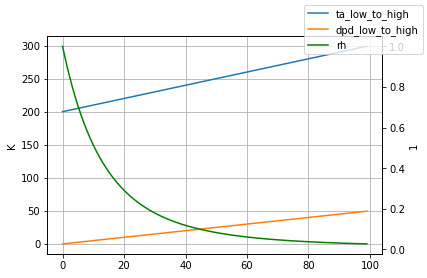

In [21]:
rh = rasotools.met.convert.to_rh(temp=ta_low_to_high, dpd=dpd_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_low_to_high')
ax.plot(range(0,100), dpd_low_to_high, label='dpd_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

<xarray.DataArray 'rh' (time: 100)>
array([1.00000e+00, 9.70544e-01, 9.41416e-01, 9.12628e-01, 8.84193e-01,
       8.56121e-01, 8.28425e-01, 8.01117e-01, 7.74207e-01, 7.47707e-01,
       7.21626e-01, 6.95975e-01, 6.70764e-01, 6.46003e-01, 6.21699e-01,
       5.97861e-01, 5.74498e-01, 5.51617e-01, 5.29226e-01, 5.07329e-01,
       4.85934e-01, 4.65046e-01, 4.44669e-01, 4.24808e-01, 4.05466e-01,
       3.86647e-01, 3.68352e-01, 3.50583e-01, 3.33342e-01, 3.16628e-01,
       3.00442e-01, 2.84782e-01, 2.69647e-01, 2.55034e-01, 2.40941e-01,
       2.27364e-01, 2.14299e-01, 2.01740e-01, 1.89683e-01, 1.78121e-01,
       1.67048e-01, 1.56455e-01, 1.46336e-01, 1.36682e-01, 1.27483e-01,
       1.18731e-01, 1.10415e-01, 1.02525e-01, 9.50510e-02, 8.79800e-02,
       8.13030e-02, 7.50070e-02, 6.90790e-02, 6.35080e-02, 5.82810e-02,
       5.33850e-02, 4.88080e-02, 4.45370e-02, 4.05590e-02, 3.68610e-02,
       3.34300e-02, 3.02530e-02, 2.73180e-02, 2.46120e-02, 2.21230e-02,
       1.98380e-02, 1.77460e

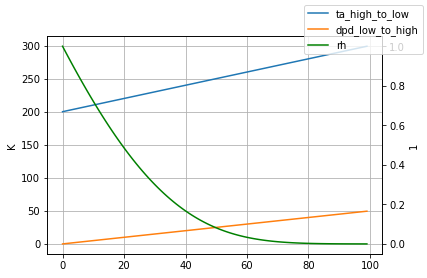

In [22]:
rh = rasotools.met.convert.to_rh(temp=ta_high_to_low, dpd=dpd_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_high_to_low')
ax.plot(range(0,100), dpd_low_to_high, label='dpd_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([ 0.      ,  2.090511,  7.254285, 14.181154, 21.936437, 29.867327,
       37.531251, 44.641178, 51.023998, 56.58895 , 61.303788, 65.176873,
       68.243826, 70.557644, 72.18147 , 73.183375, 73.632652, 73.597259,
       73.14211 , 72.327997, 71.210976, 69.842083, 68.267289, 66.527615,
       64.659359, 62.694387, 60.660471, 58.581628, 56.478479, 54.368588,
       52.26679 , 50.185495, 48.134975, 46.123624, 44.158196, 42.244018,
       40.385185, 38.584729, 36.844774, 35.166669, 33.55111 , 31.998242,
       30.507751, 29.078944, 27.710819, 26.402122, 25.151403, 23.957055,
       22.817358, 21.730505, 20.694636, 19.707854, 18.768253, 17.873923,
       17.022976, 16.213545, 15.443802, 14.71196 , 14.016279, 13.355072,
       12.726708, 12.129611, 11.562264, 11.02321 , 10.51105 , 10.024446,
        9.562115,  9.122834,  8.705435,  8.308803,  7.931878,  7.573649,
        7.233156,  6.909485,  6.601769,

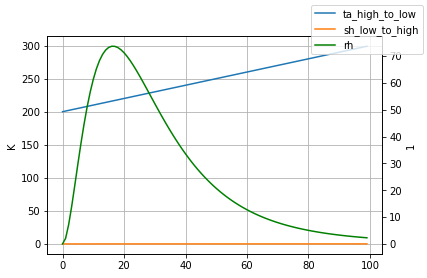

In [23]:
rh = rasotools.met.convert.to_rh(temp=ta_low_to_high, press=p_low_to_high, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([0.00000000e+00, 2.56000000e-04, 1.08500000e-03, 2.59300000e-03,
       4.89800000e-03, 8.13400000e-03, 1.24550000e-02, 1.80360000e-02,
       2.50740000e-02, 3.37940000e-02, 4.44510000e-02, 5.73340000e-02,
       7.27700000e-02, 9.11310000e-02, 1.12837000e-01, 1.38362000e-01,
       1.68246000e-01, 2.03097000e-01, 2.43606000e-01, 2.90553000e-01,
       3.44820000e-01, 4.07407000e-01, 4.79444000e-01, 5.62211000e-01,
       6.57156000e-01, 7.65918000e-01, 8.90352000e-01, 1.03256100e+00,
       1.19492200e+00, 1.38013400e+00, 1.59124800e+00, 1.83172900e+00,
       2.10550000e+00, 2.41701400e+00, 2.77131900e+00, 3.17414900e+00,
       3.63201000e+00, 4.15229300e+00, 4.74339700e+00, 5.41486800e+00,
       6.17756400e+00, 7.04384000e+00, 8.02776100e+00, 9.14534500e+00,
       1.04148490e+01, 1.18570870e+01, 1.34958060e+01, 1.53581140e+01,
       1.74749720e+01, 1.98817650e+01, 2.26189620e+01, 2.573287

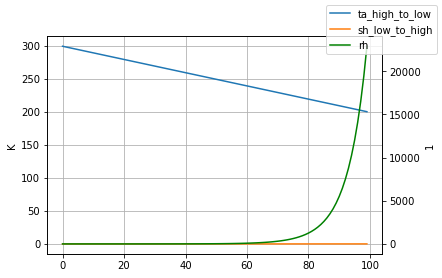

In [24]:
rh = rasotools.met.convert.to_rh(temp=ta_high_to_low, press=p_low_to_high, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_high_to_low, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([0.00000000e+00, 2.49710000e-02, 5.24710000e-02, 8.27200000e-02,
       1.15959000e-01, 1.52449000e-01, 1.92474000e-01, 2.36345000e-01,
       2.84395000e-01, 3.36993000e-01, 3.94534000e-01, 4.57453000e-01,
       5.26221000e-01, 6.01351000e-01, 6.83402000e-01, 7.72984000e-01,
       8.70759000e-01, 9.77451000e-01, 1.09384700e+00, 1.22080700e+00,
       1.35926800e+00, 1.51025100e+00, 1.67487200e+00, 1.85434600e+00,
       2.05000000e+00, 2.26328600e+00, 2.49578300e+00, 2.74922100e+00,
       3.02548800e+00, 3.32664600e+00, 3.65494800e+00, 4.01285800e+00,
       4.40306800e+00, 4.82852400e+00, 5.29244500e+00, 5.79835200e+00,
       6.35009700e+00, 6.95189500e+00, 7.60835800e+00, 8.32453000e+00,
       9.10593300e+00, 9.95861200e+00, 1.08891790e+01, 1.19048740e+01,
       1.30136190e+01, 1.42240850e+01, 1.55457590e+01, 1.69890230e+01,
       1.85652350e+01, 2.02868150e+01, 2.21673480e+01, 2.422167

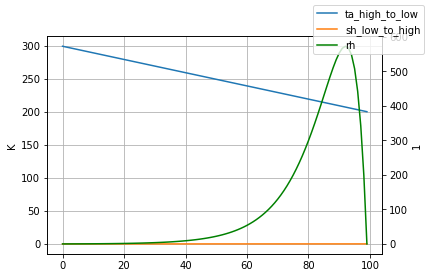

In [25]:
rh = rasotools.met.convert.to_rh(temp=ta_high_to_low, press=p_high_to_low, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_high_to_low, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([0.00000000e+00, 2.04185334e+02, 3.50681043e+02, 4.52342534e+02,
       5.19356495e+02, 5.59783460e+02, 5.79990086e+02, 5.84993774e+02,
       5.78737576e+02, 5.64309566e+02, 5.44117973e+02, 5.20031015e+02,
       4.93488564e+02, 4.65591313e+02, 4.37171955e+02, 4.08851995e+02,
       3.81087052e+02, 3.54202965e+02, 3.28424539e+02, 3.03898396e+02,
       2.80711108e+02, 2.58903571e+02, 2.38482343e+02, 2.19428593e+02,
       2.01705111e+02, 1.85261785e+02, 1.70039859e+02, 1.55975216e+02,
       1.43000883e+02, 1.31048934e+02, 1.20051901e+02, 1.09943811e+02,
       1.00660924e+02, 9.21422340e+01, 8.43297980e+01, 7.71689210e+01,
       7.06082400e+01, 6.45997240e+01, 5.90986220e+01, 5.40633650e+01,
       4.94554430e+01, 4.52392520e+01, 4.13819450e+01, 3.78532640e+01,
       3.46253750e+01, 3.16727060e+01, 2.89717890e+01, 2.65011040e+01,
       2.42409320e+01, 2.21732190e+01, 2.02814430e+01, 1.855049

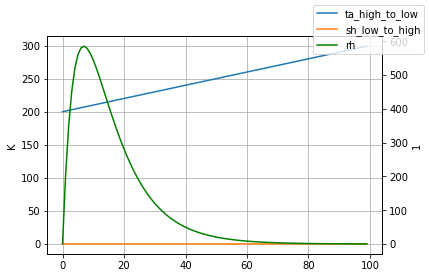

In [26]:
rh = rasotools.met.convert.to_rh(temp=ta_low_to_high, press=p_high_to_low, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

---

## converting for 72357

In [27]:
temperature = df.ta
dpd = df.dew_point_depression
sh = df.hus
p = df.plev
lon = df.lon.iloc[0]
lat = df.lat.iloc[0]
time = df.time
reference_time = pd.Timestamp(df.time.iloc[0])


In [28]:
ta = xarray.DataArray(
     data=temperature,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="K",
     ),
 )
ta

<xarray.DataArray 'ta' (time: 1630514)>
array([238.65, 244.75, 251.15, ..., 272.9 , 272.3 , 272.1 ], dtype=float32)
Coordinates:
  * time            (time) datetime64[ns] 1950-01-01T03:00:00 ... 2020-12-31T...
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:  temperature.
    units:        K

In [29]:
dpd = xarray.DataArray(
     data=dpd,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="dew_point_depression.",
         units="K",
     ),
 )
dpd

<xarray.DataArray 'dew_point_depression' (time: 1630514)>
array([ 7.19, 11.9 , 13.98, ..., 15.97,  7.95,  4.55], dtype=float32)
Coordinates:
  * time            (time) datetime64[ns] 1950-01-01T03:00:00 ... 2020-12-31T...
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:  dew_point_depression.
    units:        K

In [30]:
sh = xarray.DataArray(
     data=sh,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="specific_humidity.",
         units="1",
     ),
 )
sh

<xarray.DataArray 'hus' (time: 1630514)>
array([0.000283, 0.000286, 0.000395, ..., 0.001159, 0.002083, 0.002566],
      dtype=float32)
Coordinates:
  * time            (time) datetime64[ns] 1950-01-01T03:00:00 ... 2020-12-31T...
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:  specific_humidity.
    units:        1

In [31]:
p = xarray.DataArray(
     data=p,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="pressure.",
         units="Pa",
     ),
 )
p

<xarray.DataArray 'plev' (time: 1630514)>
array([35000., 40000., 45000., ..., 92500., 93700., 97400.])
Coordinates:
  * time            (time) datetime64[ns] 1950-01-01T03:00:00 ... 2020-12-31T...
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:  pressure.
    units:        Pa

<xarray.DataArray 'rh' (time: 1630514)>
array([0.482176, 0.311448, 0.271115, ..., 0.288282, 0.548135, 0.71193 ],
      dtype=float32)
Coordinates:
  * time            (time) datetime64[ns] 1950-01-01T03:00:00 ... 2020-12-31T...
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:    temperature.
    units:          1
    standard_name:  relativ_humidity
    long_name:      relative humidity
    esat:           HylandWexler
    origin:         t,dpd
    precision:      6


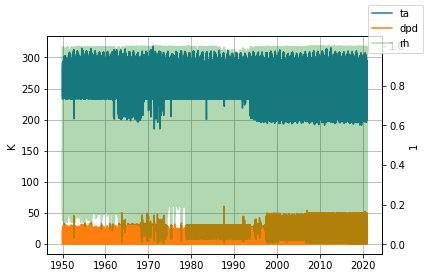

In [32]:
rh = rasotools.met.convert.to_rh(temp=ta, dpd=dpd)
print (rh)
fig, ax = plt.subplots()
ax.plot(time, ta, label='ta')
ax.plot(time, dpd, label='dpd')
ax1 = ax.twinx()
ax1.plot(time, rh, color='green', label='rh', alpha=0.3)
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

In [33]:
rh[rh < 0]

<xarray.DataArray 'rh' (time: 0)>
array([], dtype=float32)
Coordinates:
  * time            (time) datetime64[ns] 
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:    temperature.
    units:          1
    standard_name:  relativ_humidity
    long_name:      relative humidity
    esat:           HylandWexler
    origin:         t,dpd
    precision:      6

<xarray.DataArray 'rh' (time: 1630514)>
array([0.479598, 0.309479, 0.269955, ..., 0.285855, 0.54338 , 0.705777])
Coordinates:
  * time            (time) datetime64[ns] 1950-01-01T03:00:00 ... 2020-12-31T...
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:         temperature.
    units:               1
    standard_name:       relativ_humidity
    long_name:           relative humidity
    esat:                HylandWexler
    origin:              t,q,p
    enhancement_factor:  yes
    precision:           6


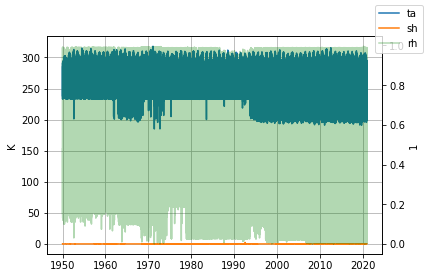

In [34]:
rh = rasotools.met.convert.to_rh(temp=ta, spec_humi=sh, press=p)
print (rh)
fig, ax = plt.subplots()
ax.plot(time, ta, label='ta')
ax.plot(time, sh, label='sh')
ax1 = ax.twinx()
ax1.plot(time, rh, color='green', label='rh', alpha=0.3)
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

In [35]:
rh[rh < 0]

<xarray.DataArray 'rh' (time: 0)>
array([], dtype=float64)
Coordinates:
  * time            (time) datetime64[ns] 
    reference_time  datetime64[ns] 1950-01-01T03:00:00
Attributes:
    description:         temperature.
    units:               1
    standard_name:       relativ_humidity
    long_name:           relative humidity
    esat:                HylandWexler
    origin:              t,q,p
    enhancement_factor:  yes
    precision:           6

---